In [1]:
import os
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import pandas as pd
import scipy.stats
import scipy.special

os.chdir("../src")
import simulator, curve_inference

In [2]:
S = simulator.Simulator(
    Ne = 10000,
    s = 0.01,
    Un = 0,
    Ud = 0.02,
    n_generations = 2000,
    random_seed = 42,
)

S.run()

In [3]:
n_muts, n_lineages = [], []
for anc, mut in zip(S.ancestors, S.all_n_mutations_selected):
    x = mut[np.array(list(anc.keys()), dtype=int)]
    n_muts.append(np.sum(x))
    n_lineages.append(len(x))

In [4]:
bin_size = 50
n_muts_binned = np.array(n_muts)[::-1].reshape((-1, bin_size)).sum(axis=1)
n_lins_binned = np.array(n_lineages)[::-1].reshape((-1, bin_size)).sum(axis=1)

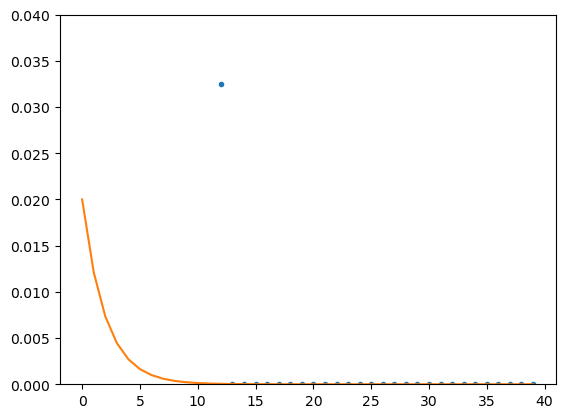

In [5]:
plt.plot(n_muts_binned / n_lins_binned, '.')
plt.plot(0.02 * np.exp(-0.01 * np.arange(0, 2000, bin_size)))
plt.ylim(0, 0.04);

## Accumulate many simulations to study mutations

In [6]:
def get_mutations_and_lineages(random_seed):
    S = simulator.Simulator(
        Ne = 10000,
        s = 0.01,
        Un = 0,
        Ud = 0.02,
        n_generations = 1000,
        random_seed = random_seed,
    )

    S.run()
    
    n_muts, n_lineages = [], []
    for anc, mut in zip(S.ancestors, S.all_new_mutations_selected):
        x = mut[np.array(list(anc.keys()), dtype=int)]
        n_muts.append(np.sum(x))
        n_lineages.append(len(x))
        
    return S, np.array(n_muts)[::-1], np.array(n_lineages)[::-1]


In [7]:
import joblib

all_res = joblib.Parallel(n_jobs=50, verbose=10)(
    joblib.delayed(get_mutations_and_lineages)(random_seed) for random_seed in range(100)
)


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done  12 out of 100 | elapsed:   30.8s remaining:  3.8min
[Parallel(n_jobs=50)]: Done  23 out of 100 | elapsed:   33.9s remaining:  1.9min
[Parallel(n_jobs=50)]: Done  34 out of 100 | elapsed:   37.4s remaining:  1.2min
[Parallel(n_jobs=50)]: Done  45 out of 100 | elapsed:   41.2s remaining:   50.4s
[Parallel(n_jobs=50)]: Done  56 out of 100 | elapsed:   51.8s remaining:   40.7s
[Parallel(n_jobs=50)]: Done  67 out of 100 | elapsed:   55.6s remaining:   27.4s
[Parallel(n_jobs=50)]: Done  78 out of 100 | elapsed:   59.1s remaining:   16.7s
[Parallel(n_jobs=50)]: Done  89 out of 100 | elapsed:  1.0min remaining:    7.7s
[Parallel(n_jobs=50)]: Done 100 out of 100 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=50)]: Done 100 out of 100 | elapsed:  1.1min finished


### Effective mutation rate 

In [8]:
n_muts = np.array([x[1] for x in all_res]).sum(axis=0)
n_lins = np.array([x[2] for x in all_res]).sum(axis=0)
   

In [9]:
bin_size = 10
n_muts_binned = n_muts.reshape((-1, bin_size)).sum(axis=1)
n_lins_binned = n_lins.reshape((-1, bin_size)).sum(axis=1)

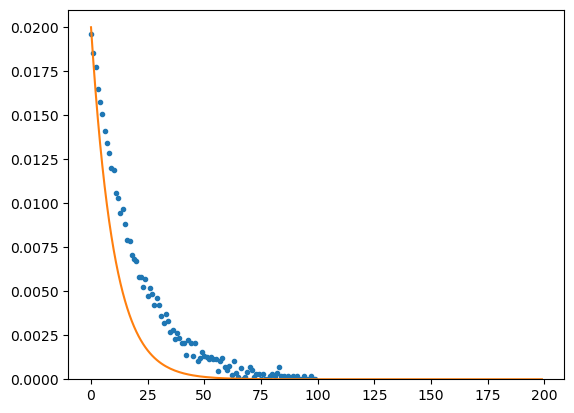

In [10]:
plt.plot(n_muts_binned / n_lins_binned, '.')
plt.plot(0.02 * np.exp(-0.01 * np.arange(0, 2000, bin_size)))
plt.ylim(0, 0.021);

### Mean ancestral class

In [11]:
all_n_total_muts = []
for S, _, _ in all_res:
    n_total_muts = []
    for anc, mut in zip(S.ancestors, S.all_n_mutations_selected):
        x = mut[np.array(list(anc.keys()), dtype=int)]
        n_total_muts.append(np.mean(x))
    n_total_muts = np.array(n_total_muts)[::-1]
    all_n_total_muts.append(n_total_muts)
    
all_n_total_muts = np.array(all_n_total_muts)

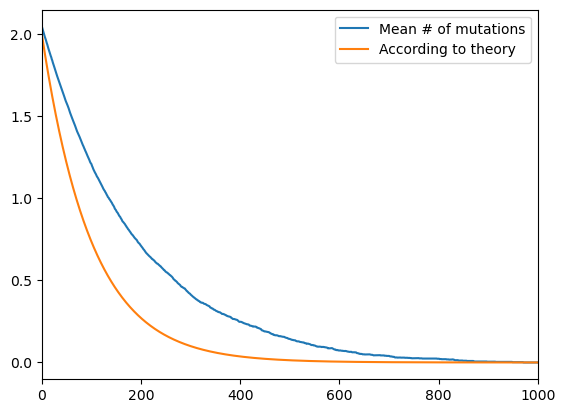

In [12]:
plt.plot(all_n_total_muts.mean(axis=0), '-', label="Mean # of mutations")
plt.plot(2*np.exp(-0.01 * np.arange(1000)), label="According to theory")
plt.xlim(0, 1000)
plt.legend()

### Steady-state distribution

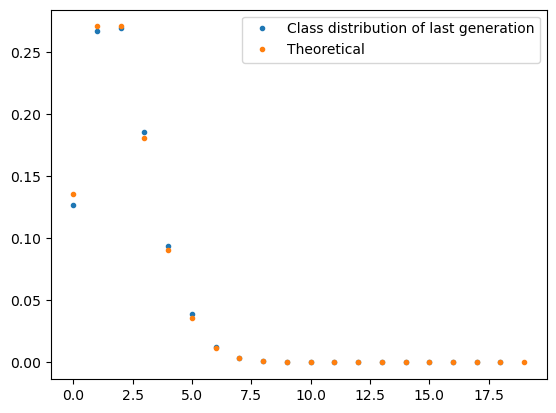

In [13]:
plt.plot(np.mean([np.histogram(S.all_n_mutations_selected[-1], bins=np.arange(20), density=True)[0] for S, _, _ in all_res], axis=0), '.', label="Class distribution of last generation")
plt.plot(scipy.stats.poisson(mu=2).pmf(np.arange(20)), '.' , label="Theoretical")
plt.legend()

In [14]:
hks = scipy.stats.poisson(mu=2).pmf(np.arange(20))

### Full ancestral state distributions

In [16]:
histme = lambda x, *args, **kwargs: np.histogram(x, np.arange(10), *args, **kwargs)[0]
nz = lambda x: np.where(x)[0]
dict_at = lambda D, at: np.array([D[x] for x in at])

In [17]:
max_T = 1000

all_asds = []
all_asds_unique = []
for S, _, _ in tqdm.tqdm(all_res):
    g = S.n_generations - 1
    which_nodes = np.arange(S.Ne)
    t = 1
    A = []
    B = []
    while t <= max_T:    
        parent_nodes = dict_at(S.ancestors[g], which_nodes)
        A.append(histme(S.all_n_mutations_selected[g-1][parent_nodes], density=True))        
        which_nodes = parent_nodes
    
        B.append(histme(S.all_n_mutations_selected[g-1][np.array(list(S.ancestors[g].values()))], density=True))        
        g -= 1
        t += 1

    all_asds.append(np.array(A))
    all_asds_unique.append(np.array(B))

all_asds = np.array(all_asds).mean(axis=0)
all_asds_unique = np.array(all_asds_unique).mean(axis=0)
ts = np.arange(1, max_T+1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


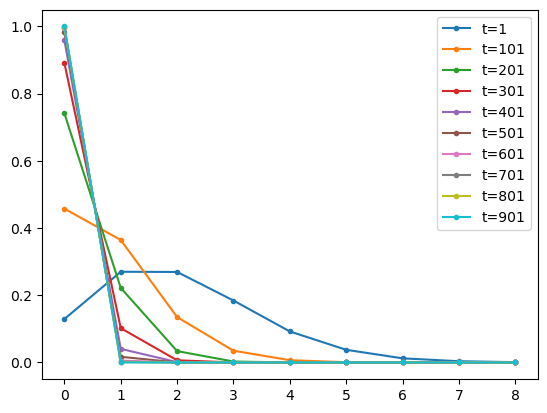

In [18]:
for t in ts[::100]:
    i = t-1
    plt.plot(all_asds[i], '.-', label=f"t={t}")
    
plt.legend()

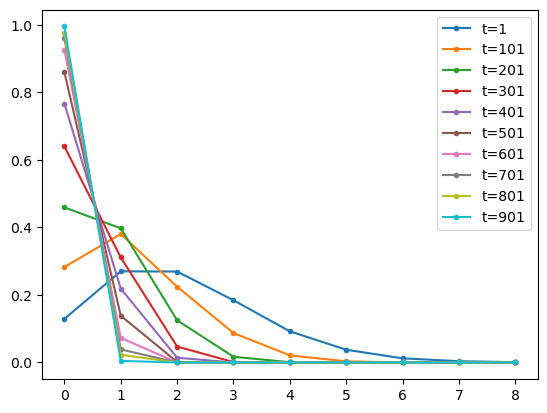

In [19]:
for t in ts[::100]:
    i = t-1
    plt.plot(all_asds_unique[i], '.-', label=f"t={t}")
    
plt.legend()

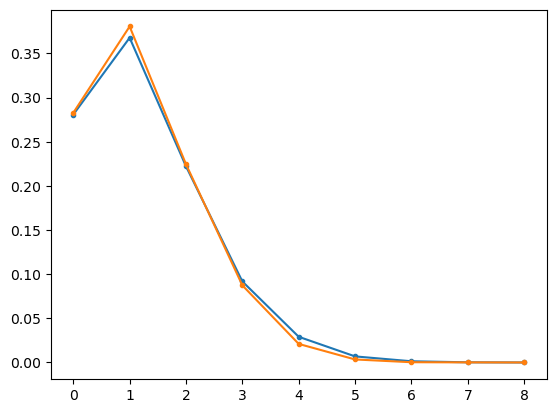

In [20]:
t = 101
i = t-1
plt.figure()
plt.plot(all_asds[i//2], '.-', label=f"t={t}, repeated")
plt.plot(all_asds_unique[i], '.-', label=f"t={t}, unique")


#### Compare the full distributions with their means

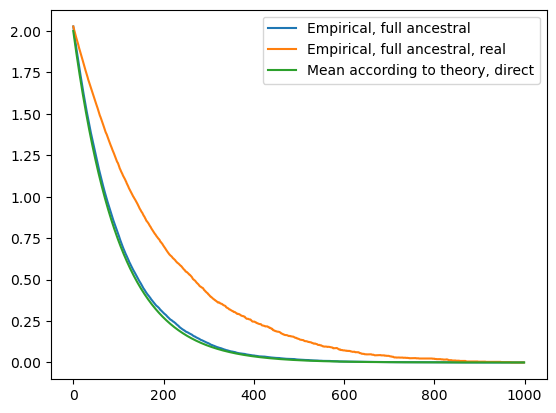

In [21]:
plt.plot([(all_asds[t-1] * np.arange(9)).sum() for t in ts[:-1]], label="Empirical, full ancestral")
plt.plot([(all_asds_unique[t-1] * np.arange(9)).sum() for t in ts[:-1]], label="Empirical, full ancestral, real")
plt.plot(2*np.exp(-0.01 * np.arange(1000)), label="Mean according to theory, direct")
plt.legend();

### Confirm Eq (2)

In [22]:
np.mean([histme(S.all_n_mutations_selected[-2][dict_at(S.ancestors[-1], nz(S.all_n_mutations_selected[-1] == 1))], density=True) \
     for S, _, _ in all_res], axis=0)

array([0.00966104, 0.99033896, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [23]:
ccs = []
for S, _, _ in all_res:
    lst = dict_at(S.ancestors[-1], nz(S.all_n_mutations_selected[-1] == 6))
    ccs.append([len(lst), len(np.unique(lst))])
    
ccs = np.array(ccs)

In [24]:
(ccs[:,1]/ccs[:,0]).mean()

0.6768172443436768

In [25]:
frac_uniq = 0.632  # len(np.unique(np.random.choice(10000000, 10000000)))

In [26]:
np.mean([len(np.unique(x))/len(x) for x in np.random.choice(50, (10000, 50))])

0.6358659999999999

### Confirm Eq (4)

In [27]:
ki = 1
max_T = 500

all_As = []
all_As_unique = []

all_classes = []
for S, _, _ in tqdm.tqdm(all_res):
    g = S.n_generations - 1
    which_nodes = nz(S.all_n_mutations_selected[g] == ki)
    t = 1
    A = []
    A_unique = []
    classes = []
    while t <= max_T:    
        parent_nodes = dict_at(S.ancestors[g], which_nodes)
        parent_nodes_unique = np.unique(parent_nodes)
        A.append(histme(S.all_n_mutations_selected[g-1][parent_nodes], density=True))        
        A_unique.append(histme(S.all_n_mutations_selected[g-1][parent_nodes_unique], density=True))
        classes.append(S.all_n_mutations_selected[g-1][parent_nodes])
        which_nodes = parent_nodes
        g -= 1
        t += 1

    all_As.append(np.array(A))
    all_As_unique.append(np.array(A_unique))
    all_classes.append(np.array(classes))

all_As = np.array(all_As).mean(axis=0)
all_As_unique = np.array(all_As_unique).mean(axis=0)
ts = np.arange(1, max_T+1)



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.22it/s]


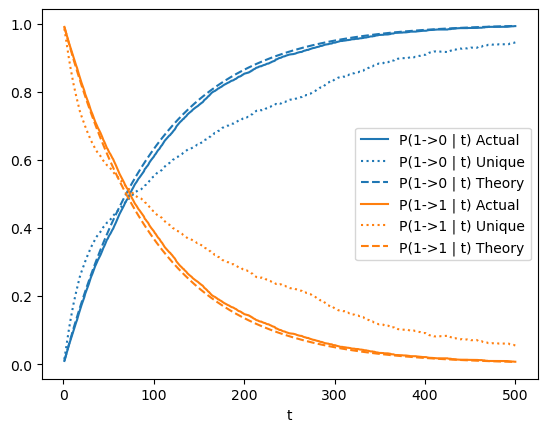

In [28]:
for kf in range(ki+1):
    plt.plot(ts, all_As[:, kf], label=f"P({ki}->{kf} | t) Actual", color="C"+str(kf))
    plt.plot(ts, all_As_unique[:, kf], label=f"P({ki}->{kf} | t) Unique", ls='dotted', color="C"+str(kf))
    plt.plot(ts, np.exp(-0.01 * ki * ts) * (np.exp(0.01 * ts) - 1)**(ki-kf) * scipy.special.comb(ki, kf), ls='--', label=f"P({ki}->{kf} | t) Theory", color="C"+str(kf))

plt.xlabel("t")
plt.legend()


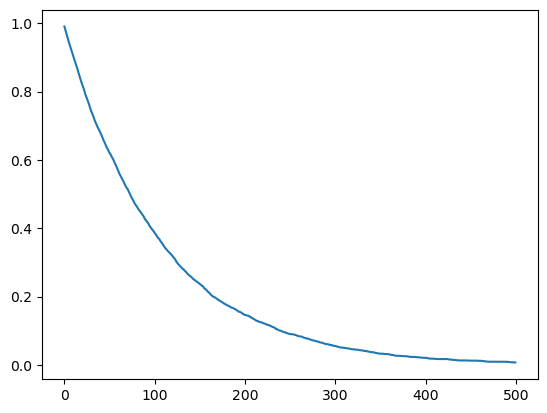

In [29]:
plt.plot(np.mean([x.mean(axis=1) for x in all_classes], axis=0))


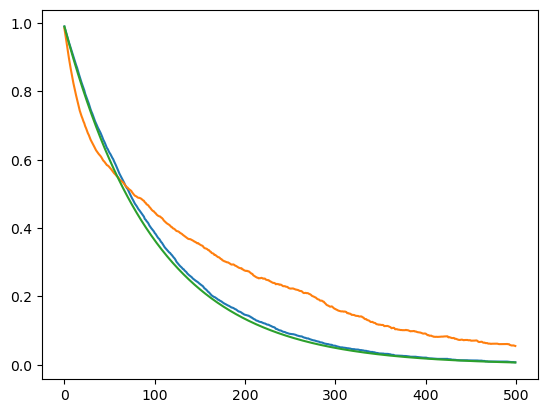

In [30]:
plt.plot(all_As @ np.arange(9))
plt.plot(all_As_unique @ np.arange(9))
plt.plot(np.exp(-0.01 * ts))

# Ne?

In [31]:
all_n_lineages = np.array([x[2] for x in all_res])

In [32]:
max_generations = 1000

xs = np.concatenate([np.arange(0,500,10), np.arange(500, max_generations, 100)])


In [33]:
estimates = curve_inference.infer_Ne(all_n_lineages, xs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  54 | elapsed:    1.6s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done  11 out of  54 | elapsed:    1.7s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  17 out of  54 | elapsed:    1.7s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  23 out of  54 | elapsed:    1.7s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  29 out of  54 | elapsed:    1.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  35 out of  54 | elapsed:    1.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  41 out of  54 | elapsed:    1.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  47 out of  54 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    1.8s finished


In [34]:
def effective_pop_size_pairwise(t1, t2, N, Ud, s):
    """
    t1 and t2 can be vectors
    """
    t1 = np.maximum(t1, -1)
    t2 = np.maximum(t2, -1)
    
    prob_coal = 1/N * np.exp(Ud/s * (1 - np.exp(-s * t1)) * (1 - np.exp(-s * t2)))
    
    # support negative times
    Ne = np.where((t1 >= 0) & (t2 >= 0), 1/prob_coal, np.nan)
    
    return Ne
    
 
    

In [35]:
N = 1e4
s = 1e-2
Ud = s * 2

ts = np.arange(0, max_generations)

theory_Ne = effective_pop_size_pairwise(ts, ts, N, Ud, s)



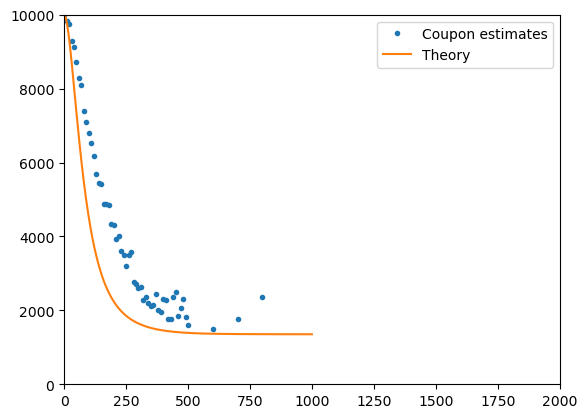

In [36]:
plt.plot(xs[:-1], estimates, '.', label="Coupon estimates")
plt.plot(ts, theory_Ne, label="Theory")
plt.xlim(0,2000)
plt.ylim(0, 10000)
plt.legend()